In [1]:
# import necessary libraries
import re, string, unicodedata
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier


#Balanceo de clases y variables
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA


SEED=42

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

In [3]:
# cargar los datos
df_original = pd.read_csv('data/tipo1_entrenamiento_estudiantes.csv')

# Entendimiento

In [4]:
df_original.shape

(7875, 2)

In [5]:
df_original.sample(5)

,Review,Class
275,"bonita arquitectura, linda ciudadlo malo la prostituciontours adecuadobuena tour de guiafalta restaurarla",3
2071,"Es toda una experiencia estar de frente a estos animalea que se encuentran practicamente libres, es muy agradable, hay gran variedad de animales, hay una zona al final del recorrido donde se pueden observar varios animales en en habitats mas pequeños, y los espectaculos que presentan tambien son muy bueno.",4
683,"Primera vez en Vallarta, los shows street neon y concierto de rock excelentes además me encantaron las actividades con los chicos de animación: Israel, Bryan,Aldair, Iris,Fede, Liz, Canelo, Alex, Chuy y Mawy.\nRecalcó el excelente servicio de los restaurantes el que más me gustó fue el Ipanema buen servicio de meseros, volveremos seguramente",5
44,Al ser un edificio de construcción redonda el ruido del lobby se escucha en todas las habitaciones. El personal de recepción no atiende a llamado la para solucionar temas graves No recomiendo este hotel,1
235,"Muy austero, la comida no sabe bien, alejado de buenos lugares para comer, ubicado en una zona donde el acceso es muy complicado después de las 10pm debido a construcciones de un puente, el restaurante bar agrega sin permiso la propina en el recibo. El elevador se descompuso y no había escaleras para subir a los cuartos.",2


In [6]:
df_original.isnull().sum()

Review    0
Class     0
dtype: int64

No hay registros nulos, los datos son completos.

<Axes: xlabel='Class'>

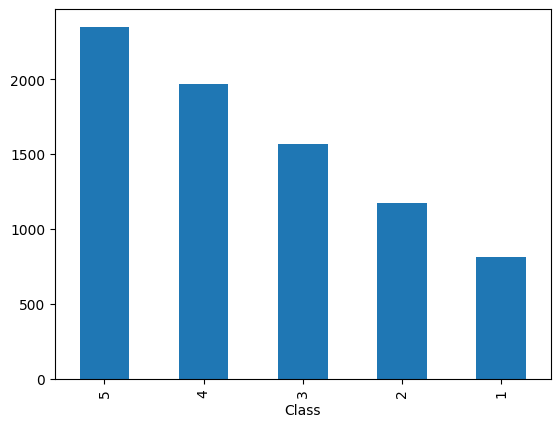

In [7]:
# distribución de variable objetivo
df_original['Class'].value_counts().plot(kind='bar')

Todos los valores de la columna 'Class' son válidos.

In [8]:
df_original.duplicated().sum()

71

Hay 71 registro duplicados, estos se deben eliminar del dataset.

In [9]:
duplicated_rows = df_original[df_original.duplicated()]
duplicated_rows


,Review,Class
518,"La ubicación es muy buena, al igual que la vista, la playa contrario a lo que esperaba resultó que estaba bastante limpia.\nSe percibe el sabor y la frescura en los insumos de los alimentos , lo cual es parte de la experiencia que ofrece...el lugar ya que tienen sus propias granjas productoras. La carta es limitada ( lo cual en mi caso prefiero, ya que se nota el esmero en cada uno de los platos que preparan), los precios están por arriba del promedio de otros restaurantes cercanos pero no llegan a ser exagerados, desconozco si eso se debió a que solo se tenía un salón disponible, ya que en la fecha que lo visité, el resto del restaurante se encontraba en remodelación (es la único razón por lo cual no otorgo la evaluación más alta), mi sugerencia sería que siguieran manteniendo los precios ya que los hace muy competitivos … sin duda regresaría, es un lugar que debes visitar en Veracruz sobre todo si eres fanático del buen comer…Más",4
1112,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
1605,"Cierran a las 3 pm, cobraron $85 adultos y niños (por lo menos los de 2 años) y adulto mayor gratis. A la entrada hay guías. Se juntan grupos de mínimo 10 personas y te cobran $70 por persona o $700 a quien se los pague. Excelente explicación y atención de parte de ellos. Poca claridad de información en redes, y el número telefónico no sirve. Llegamos fácilmente con waze. Lleven buen bloqueador, sombrero y de preferencia tenis.",3
1843,"Acudimos un sábado 2 de julio a las 11:15 de la mañana. Estuvimos esperando más de media hora nosotros dos y otro grupo de cuatro personas fuera, porque la camarera estaba dentro. Nos vio como estábamos esperando y no fue capaz de salir a atendernos...o dar alguna explicación si el bar estaba abierto o cerrado.\n\nNos tuvimos que marcharMás",1
1851,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
...,...,...
7520,"Un lugar muy limpio ordenado hermoso con áreas amplias que vale la pena disfrutar en familia un momento, primera vez que lo visito pero vale la pena acudir.",3
7601,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
7756,Deben de actualizar los horarios en las diferentes páginas ya que como yo o cualquiera de los visitantes que vamos podemos llegar y encontrar cerrado y luego la página para buscar información no funciona.,3
7794,"Wow Había escuchado muchas recomendaciones de este lugar, pero nunca había ido, hace unos fui y me precio muy interesante toda las historias que hay en este museo.",5


# Procesamiento y Preparación

In [10]:
# eliminar las filas duplicadas
df_prep = df_original.drop_duplicates()

In [11]:
df_prep.shape

(7804, 2)

## Divisón en entrenamiento y prueba 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_prep["Review"], df_prep["Class"], test_size = 0.2, stratify = df_prep["Class"], random_state = SEED)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6243,), (1561,), (6243,), (1561,))

## Tokenización / Vectorización

"Feature engineering"

* Bag of Words / Count Tokenizer
* Tf-IDF

In [15]:
# Descargar los datos necesarios
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andresarevalo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andresarevalo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
stop_words = set(stopwords.words('spanish'))

In [17]:
def tokenize_text(text):
    # convertir a minúsculas
    text = text.lower()

    # eliminar caracteres numericos
    text = re.sub(r'\d+', '', text)

    # eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))

    # eliminar caracters especiales
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"
                            u"\U0001F300-\U0001F5FF"
                            "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') 

    tokens = word_tokenize(text)

    # eliminar las stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # eliminar los stems de las palabras
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

In [18]:
bow_vectorizer = CountVectorizer(stop_words=list(stop_words), lowercase=True, tokenizer=tokenize_text)
tfidf_vectorizer = TfidfVectorizer( stop_words=list(stop_words), lowercase=True, tokenizer=tokenize_text)

In [19]:
X_train_bow = bow_vectorizer.fit_transform(X_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eram', 'estab', 'estais', 'estan', 'estareis', 'estari', 'estariais', 'esteis', 'esten', 'estes', 'estuvier', 'estuvies', 'fuer', 'fues', 'habeis', 'habi', 'habiais', 'habr', 'habreis', 'habri', 'habriais', 'hayais', 'hubier', 'hubies', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'ser', 'sereis', 'seri', 'seriais', 'si', 'tambi', 'tendr', 'tendreis', 'tendri', 'tendriais', 'teneis', 'tengais', 'teni', 'teniais', 'tuvier', 'tuvies'] not in stop_words.
  warnings.warn(


In [20]:
len(bow_vectorizer.vocabulary_)

13475

In [21]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [22]:
len(tfidf_vectorizer.vocabulary_)

13475

In [23]:
df_bow_sklearn = pd.DataFrame(X_train_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())
df_bow_sklearn

,...,......,8,aa,aaaaa,aaaah,aasequ,ab,abad,abaj,...,zonatambi,zoo,zoofari,zoolog,zorr,zotan,zuegly,zul,zum,zumb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6240,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#FRECUENCIA DE PALABRAS

# Obtener el vocabulario
vocabulario = bow_vectorizer.vocabulary_
# Obtener la suma de las frecuencias de cada palabra en todo el conjunto de datos
frecuencia_total = X_train_bow.sum(axis=0)
# Crear un diccionario que mapea cada palabra a su frecuencia total
frecuencias = {palabra: frecuencia_total[0, indice] for palabra, indice in vocabulario.items()}

# Convertir el diccionario de frecuencias en un DataFrame
df_frecuencias = pd.DataFrame(list(frecuencias.items()), columns=['Palabra', 'Frecuencia'])

# Ordenar el DataFrame por frecuencia de forma descendente
df_frecuencias = df_frecuencias.sort_values(by='Frecuencia', ascending=False)
# Imprimir las frecuencias de cada palabra
df_frecuencias

,Palabra,Frecuencia
86,hotel,3236
118,buen,2831
313,com,2369
97,habit,2360
116,mas,2114
...,...,...
8407,lucidor,1
8406,blamang,1
8405,ofrend,1
8404,excelentevolveri,1


In [25]:
df_palabras_altafrec = df_frecuencias[df_frecuencias['Frecuencia'] > 50]
df_palabras_altafrec.describe()

,Frecuencia
count,778.000000
mean,216.021851
std,294.307561
min,51.000000
25%,74.250000
50%,119.000000
75%,245.500000
max,3236.000000


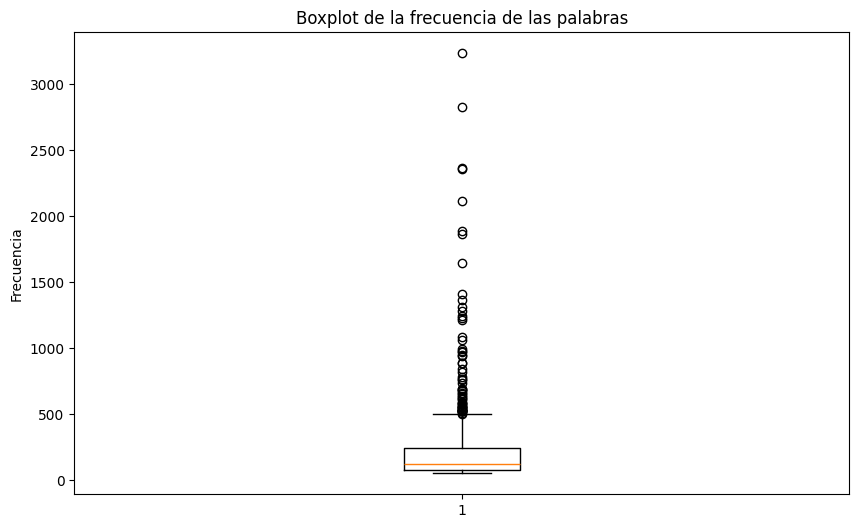

In [26]:
#Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_palabras_altafrec['Frecuencia'])
plt.title('Boxplot de la frecuencia de las palabras')
plt.ylabel('Frecuencia')
plt.show()

In [27]:
# Obtener las palabras de alta frecuencia como una lista
palabras_altafrecuencia = df_palabras_altafrec['Palabra'].tolist()

# Filtrar las columnas que coinciden con las palabras de alta frecuencia
df_bow_sklearn_filtrado = df_bow_sklearn[palabras_altafrecuencia]

len(df_bow_sklearn_filtrado.columns)

778

In [28]:
# Convertir el DataFrame de nuevo a un array de NumPy
X_train_bow_filtrado = df_bow_sklearn_filtrado.to_numpy()
X_train_bow_filtrado.shape

(6243, 778)

# Entrenamiento y evaluación de modelos

## Random Forest

Desarrollado por: Andrés Arévalo

El algoritmo Random Forest es un método de aprendizaje automático basado en árboles de decisión que se utiliza tanto para tareas de clasificación como de regresión. En el contexto del análisis de texto, Random Forest utiliza una técnica de conjunto (ensemble) donde se construyen múltiples árboles de decisión, cada uno entrenado con una muestra aleatoria de las características y registros disponibles. Para el análisis de texto, los árboles de decisión en Random Forest evalúan las palabras presentes en cada reseña para determinar la clasificación. A medida que cada árbol realiza su propia predicción, la clasificación final se determina por votación mayoritaria entre todos los árboles en el bosque. Esto significa que cada árbol contribuye con su propia opinión sobre la clasificación de una reseña, y la decisión final se toma en base a la opinión colectiva del conjunto de árboles.

In [29]:
X_test_bow = bow_vectorizer.transform(X_test)

In [30]:
# Convertir la matriz dispersa X_test_bow a un DataFrame
df_X_test_bow = pd.DataFrame(X_test_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())

# Filtrar las columnas que coinciden con las palabras de alta frecuencia
df_X_test_bow_filtrado = df_X_test_bow[palabras_altafrecuencia]
print(len(df_X_test_bow_filtrado.columns))
# Convertir el DataFrame de nuevo a un array de NumPy
X_test_bow_filtrado = df_X_test_bow_filtrado.to_numpy()


778


### Random Forest: Sin frecuencias y 250 estimadores

#### Entrenamiento

In [31]:
# Crear el clasificador de Random Forest
random_forest_1 = RandomForestClassifier(n_estimators=250, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest_1.fit(X_train_bow, y_train)

RandomForestClassifier(n_estimators=250, random_state=42)

#### Evaluación

In [32]:
#Metricas
y_pred_train = random_forest_1.predict(X_train_bow)
y_pred_test = random_forest_1.predict(X_test_bow)

precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print('Precisión en entrenamiento:', precision_train)
print('Precisión en prueba:', precision_test)

print('Recall en entrenamiento:', recall_train)
print('Recall en prueba:', recall_test)

print('F1 en entrenamiento:', f1_train)
print('F1 en prueba:', f1_test)

Precisión en entrenamiento: 1.0
Precisión en prueba: 0.4436416140868148
Recall en entrenamiento: 1.0
Recall en prueba: 0.4561178731582319
F1 en entrenamiento: 1.0
F1 en prueba: 0.42715182693506737


### Random Forest: Umbral frecuencias palabras y 150 estimadores

#### Entrenamiento

In [33]:
# Crear el clasificador de Random Forest
random_forest_2 = RandomForestClassifier(n_estimators=150, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest_2.fit(X_train_bow_filtrado, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

#### Evaluación

In [34]:
#Metricas
y_pred_train = random_forest_2.predict(X_train_bow_filtrado)
y_pred_test = random_forest_2.predict(X_test_bow_filtrado)

precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print('Precisión en entrenamiento:', precision_train)
print('Precisión en prueba:', precision_test)

print('Recall en entrenamiento:', recall_train)
print('Recall en prueba:', recall_test)

print('F1 en entrenamiento:', f1_train)
print('F1 en prueba:', f1_test)

Precisión en entrenamiento: 1.0
Precisión en prueba: 0.43824363160291985
Recall en entrenamiento: 1.0
Recall en prueba: 0.4497117232543241
F1 en entrenamiento: 1.0
F1 en prueba: 0.4337937056521637


### Random Forest: Umbral frecuencias palabras, 250 estimadores, Max Depth 30

#### Entrenamiento

In [35]:
# Crear el clasificador de Random Forest
random_forest_3 = RandomForestClassifier(n_estimators=250, max_depth=30, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest_3.fit(X_train_bow_filtrado, y_train)

RandomForestClassifier(max_depth=30, n_estimators=250, random_state=42)

#### Evaluación

In [36]:
#Metricas
y_pred_train = random_forest_3.predict(X_train_bow_filtrado)
y_pred_test = random_forest_3.predict(X_test_bow_filtrado)

precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print('Precisión en entrenamiento:', precision_train)
print('Precisión en prueba:', precision_test)

print('Recall en entrenamiento:', recall_train)
print('Recall en prueba:', recall_test)

print('F1 en entrenamiento:', f1_train)
print('F1 en prueba:', f1_test)

Precisión en entrenamiento: 0.9105185548735883
Precisión en prueba: 0.42333577420881147
Recall en entrenamiento: 0.8926798013775429
Recall en prueba: 0.438821268417681
F1 en entrenamiento: 0.8943910823438154
F1 en prueba: 0.4065870266257479


### Random Forest: Umbral frecuencias palabras y 250 estimadores

#### Entrenamiento

In [37]:
# Crear el clasificador de Random Forest
random_forest_4 = RandomForestClassifier(n_estimators=250, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest_4.fit(X_train_bow_filtrado, y_train)

RandomForestClassifier(n_estimators=250, random_state=42)

#### Evaluación

In [38]:
#Metricas
y_pred_train = random_forest_4.predict(X_train_bow_filtrado)
y_pred_test = random_forest_4.predict(X_test_bow_filtrado)

precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print('Precisión en entrenamiento:', precision_train)
print('Precisión en prueba:', precision_test)

print('Recall en entrenamiento:', recall_train)
print('Recall en prueba:', recall_test)

print('F1 en entrenamiento:', f1_train)
print('F1 en prueba:', f1_test)

Precisión en entrenamiento: 1.0
Precisión en prueba: 0.44436526403334653
Recall en entrenamiento: 1.0
Recall en prueba: 0.4548366431774504
F1 en entrenamiento: 1.0
F1 en prueba: 0.4383480411996237


### Reporte de métricas Mejor Modelo Random Forest 

In [39]:
from sklearn.metrics import classification_report

y_pred = random_forest_4.predict(X_test_bow_filtrado)
# Obtener el informe de clasificación
report = classification_report(y_test, y_pred)

# Imprimir el informe de clasificación
print(report)


              precision    recall  f1-score   support

           1       0.53      0.25      0.34       158
           2       0.38      0.34      0.36       232
           3       0.38      0.30      0.33       310
           4       0.39      0.39      0.39       393
           5       0.54      0.75      0.63       468

    accuracy                           0.45      1561
   macro avg       0.44      0.40      0.41      1561
weighted avg       0.44      0.45      0.44      1561



### Análisis de Resultados Mejor Modelo Random Forest : Entendimiento de palabras con mayor importancia por clase. 

In [40]:
# Obtener la importancia de las variables
importances = random_forest_4.feature_importances_

# Obtener los nombres de las variables
feature_names = np.array(df_bow_sklearn_filtrado.columns)

# Crear un diccionario con la importancia de cada variable
feature_importance_dict = dict(zip(feature_names, importances))

# Ordenar las variables por su importancia
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Crear una lista para almacenar las variables más relevantes
top_features = []

# Imprimir las variables ordenadas por su importancia y guardar las más relevantes en la lista
for feature, importance in sorted_feature_importance:
    if importance > 0.004:
        print(f"{feature}: {importance}")
        top_features.append((feature, importance))

# Convertir la lista de tuplas en una nueva tupla
top_features_tuple = tuple(top_features)

# Verificar las variables más relevantes guardadas en la nueva tupla
print("Top features:", top_features_tuple)

excelent: 0.013847523329354664
mal: 0.013807121406355854
buen: 0.009767358804765439
habit: 0.008254145012191325
hotel: 0.007548745939129834
lug: 0.006774000968154763
mas: 0.0066776238106899454
com: 0.006631979083615405
pesim: 0.006544804208531
si: 0.005672693369727765
servici: 0.005531179162717607
bien: 0.005304308760942602
recomend: 0.00519168013907594
mejor: 0.005184304968774137
suci: 0.005145544657259741
sol: 0.005051547202132716
visit: 0.004985055244091132
peor: 0.004857506774571444
pued: 0.004824944588934375
restaur: 0.004543962628907699
habi: 0.004436478777472449
hac: 0.004373563571986233
vist: 0.0043177849176939224
ciud: 0.00427425460201152
haban: 0.00426795625390923
atencion: 0.004227667117927382
lleg: 0.004223217970796804
Top features: (('excelent', 0.013847523329354664), ('mal', 0.013807121406355854), ('buen', 0.009767358804765439), ('habit', 0.008254145012191325), ('hotel', 0.007548745939129834), ('lug', 0.006774000968154763), ('mas', 0.0066776238106899454), ('com', 0.006631

In [42]:
import pandas as pd

# Crear un DataFrame para y_train con el nombre de la columna 'class'
df_y_train = pd.DataFrame({'class': y_train})

# Resetear los índices de df_y_train
df_y_train.reset_index(drop=True, inplace=True)

# Crear un DataFrame para X_train_bow con las palabras de alta frecuencia como columnas
df_X_train_bow = pd.DataFrame(data=X_train_bow_filtrado, columns=palabras_altafrecuencia)

# Concatenar los dos DataFrames a lo largo de las columnas (axis=1)
df_results = pd.concat([df_X_train_bow, df_y_train], axis=1)

# Verificar el DataFrame resultante
print(df_results)



      hotel  buen  com  habit  mas  si  lug  servici  bien  pued  ...  obvi  ingres  cont  exposicion  sop  fabul  huel  adicional  respect  class
0         0     0    0      0    0   0    0        0     0     0  ...     0       0     0           0    0      0     0          0        0      5
1         0     0    0      0    0   0    0        0     0     0  ...     0       0     0           0    0      0     0          0        0      3
2         0     0    0      0    0   0    0        1     0     0  ...     0       0     0           0    0      0     0          0        0      5
3         0     0    0      0    0   0    1        0     0     0  ...     0       0     0           0    0      0     0          0        0      5
4         2     1    0      1    1   0    0        0     1     0  ...     1       0     0           0    0      0     0          0        0      3
...     ...   ...  ...    ...  ...  ..  ...      ...   ...   ...  ...   ...     ...   ...         ...  ...    ...   ..

In [43]:
# Agrupar por clase y sumar las ocurrencias de cada palabra
word_counts_by_class = df_results.groupby('class').sum()
word_counts_by_class

# Crear un DataFrame solo con las top features
df_top_features = word_counts_by_class[list(dict(top_features).keys())]

# Verificar el DataFrame resultante
print(df_top_features)

       excelent  mal  buen  habit  hotel  lug  mas  com  pesim   si  ...  peor  pued  restaur  habi  hac  vist  ciud  haban  atencion  lleg
class                                                                ...                                                                   
1            11  258   149    381    529  161  246  262    105  233  ...    82    95      122   199  164    51    37     77        72   187
2            48  346   374    657    767  245  417  388     51  344  ...    56   220      188   218  238   129    86    143        90   235
3           116  181   631    584    757  365  542  464     26  487  ...    26   262      261   204  288   220   158    249       117   204
4           276   61   971    442    651  533  449  558      3  460  ...     6   400      332   125  270   293   297    280       124   141
5           611   40   706    296    532  561  460  697      2  367  ...     3   389      407    93  280   297   308    231       290   172

[5 rows x 27 column

In [44]:
# Iterar sobre las clases
for class_label in df_top_features.index:
    # Obtener las palabras con una frecuencia mayor o igual a 100 para la clase actual
    top_words = df_top_features.loc[class_label][df_top_features.loc[class_label] >= 100].sort_values(ascending=False)
    # Imprimir las palabras y sus frecuencias para la clase actual
    print(f"Clase {class_label}:")
    print(top_words)
    print("-----------------------")

Clase 1:
hotel      529
habit      381
com        262
mal        258
mas        246
si         233
habi       199
servici    192
lleg       187
hac        164
lug        161
sol        159
buen       149
restaur    122
mejor      111
suci       109
pesim      105
bien       102
Name: 1, dtype: int64
-----------------------
Clase 2:
hotel      767
habit      657
mas        417
com        388
buen       374
mal        346
si         344
servici    288
sol        267
lug        245
mejor      243
hac        238
lleg       235
pued       220
habi       218
bien       215
restaur    188
haban      143
vist       129
visit      120
suci       106
Name: 2, dtype: int64
-----------------------
Clase 3:
hotel       757
buen        631
habit       584
mas         542
si          487
com         464
lug         365
bien        347
sol         322
mejor       308
servici     296
hac         288
pued        262
restaur     261
visit       255
haban       249
vist        220
lleg        204
habi    